# Solving a routing problem using GA

This problem addresses using the genetic algorithm to find the shortest path between two points of interest in Vaughan, a municipality to the north of Toronto.

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

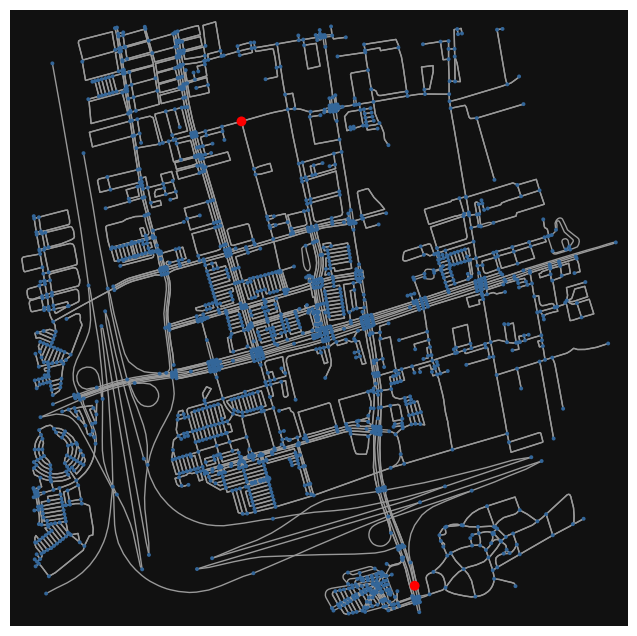

In [2]:
import osmnx

G = osmnx.graph_from_address('vaughan', dist=1400)

origin = 29658954
destination = 701446851

highlighted = [origin, destination]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [3]:
from optalgotools.structures import Node
def shortest_path_with_failed_nodes(G, route ,i,j, failed : list):
    source = route[i-1]
    target = route[j+1]
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = target)

    ## you can't introduce failure in the source and target
    # node, because your problem will lose its meaning
    if source in failed: failed.remove(source)
    if target in failed: failed.remove(target)
    
    # if after removing source/target node from failed
    # list - just return math.inf which is equivalent to failure in search
    if len(failed) == 0: return math.inf

    # we need to flag every node whether it is failed or not
    failure_nodes = {node: False for node in G.nodes()}
    failure_nodes.update({node: True for node in failed})

    # we need to make sure that while expansion we don't expand
    # any node from the original graph to avoid loops in our route
    tabu_list = route[:route.index(source)] \
                + \
                route[route.index(target) + 1:] 

    # the normal implementation of dijkstra
    shortest_dist = {node: math.inf for node in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = node) for node in G.nodes()]
    seen = set()

    shortest_dist[source] = 0

    while len(unrelaxed_nodes) > 0:
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node])

        # if we have relaxed articulation nodes in our graph
        # halt the process -- we have more than one component
        # in our graph which makes the question of shortest path
        # invalid

        if shortest_dist[node.osmid] == math.inf: return math.inf

        if node == destination:
            return node.path(),i,j, route

        unrelaxed_nodes.remove(node); seen.add(node.osmid) # relaxing the node

        for child in node.expand():
            # if it is failed node, skip it
            if failure_nodes[child.osmid] or\
                child.osmid in seen or\
                child.osmid in tabu_list:
                continue

            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance

            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node

    # in case the node can't be reached from the origin
    # this return happens when the node is not on the graph
    # at all, if it was on a different component the second
    # return will be executed -- this is the third return
    
    return math.inf

In [4]:
def shortest_path_with_failed_nodes_single(G,route,failed:list):
    i = 1
    j = len(route) -2
    result = shortest_path_with_failed_nodes(G,route,i,j,failed)
    if result is math.inf: return result
    path, i,j, r = result
    return r

In [5]:
import random
import math

def mutate(G, route):
    source = route[0]
    destination = route[-1]

    failed = random.choice(route)

    path = shortest_path_with_failed_nodes_single(G, route, [failed])

    # This method could fail because of a lot of factors relating to the graph structure
    # Check the documentation fo the shortest_path_with_failed_nodes to learn more
    while path == math.inf:
        failed = random.choice(route)
        path = shortest_path_with_failed_nodes_single(G, route, [failed])
    
    return path

In [6]:
def probability(p):
    return p > random.uniform(0.0, 1.0)

In [7]:
import itertools

def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[-1]

    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]
    
    if len(intersection) == 0: return route_1 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    if probability(0.50):
        return route_1[:first_point] + route_2[second_point:]
    else:
        return route_2[:second_point] + route_1[first_point:]

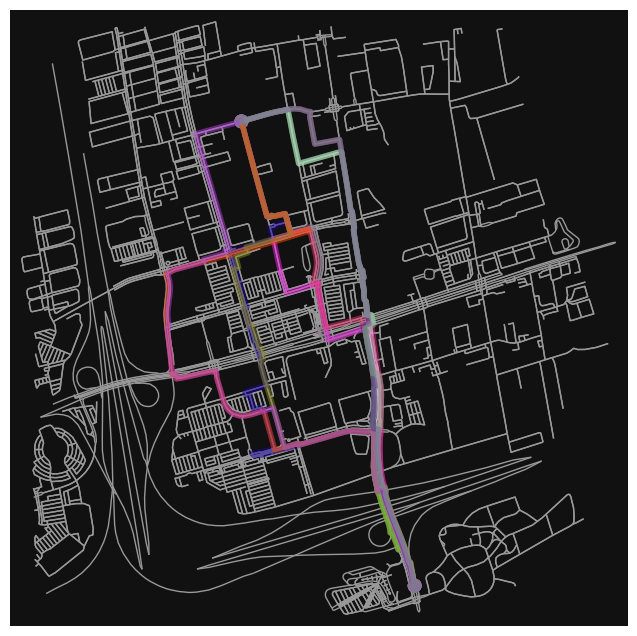

In [8]:
from optalgotools.routing import randomized_search

# Configure some parameters
n_gen = 100 # Anything above 20 will take some time but yield much better results
pool_size = 12 # Number of routes in each generation
parents_num = 4 # needs to be a factor of pool size

# Initialize the pool
pool = [randomized_search(G,origin,destination) for _ in range(pool_size)]

# Plot the pool on a map
random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(pool_size)]
fig, ax = osmnx.plot_graph_routes(G, pool, route_colors=rc, route_linewidth=6, node_size=0)

In [9]:
def cost(G, route):
    weight = 0
    for u, v in zip(route, route[1:]):
        weight += G[u][v][0]['length']   
    return round(weight,4)

In [10]:
"""
Flatten a list of lists
"""
def flatten(list2d):
    return list(itertools.chain(*list2d))

In [11]:
import itertools

def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[-1]

    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]
    
    if len(intersection) == 0: return route_1 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    if probability(0.50):
        return route_1[:first_point] + route_2[second_point:]
    else:
        return route_2[:second_point] + route_1[first_point:]

In [12]:
from tqdm.notebook import tqdm
import heapq

states = []

def select_best(pool, num_of_choices, probability_dist):
        return random.choices(population=pool, weights=probability_dist, k= num_of_choices)

for gen in tqdm(range(n_gen)):
    weights = [cost(G, route) for route in pool]
    parents_1 = select_best(pool, parents_num, weights)
    parents_2 = [cross_over(route_1, route_2) for route_1, route_2 in itertools.combinations(parents_1, r = 2)]
    pool.extend([mutate(G, route) for route in parents_2])
    pool = [*map(list, list(set(map(tuple, pool))))]
    num_removed = pool_size - len(pool) + 1
    pool.extend([randomized_search(G, origin, destination) for _ in range(num_removed)])
    pool = heapq.nsmallest(pool_size,pool,key=lambda x: cost(G,x))
    m = cost(G, min(pool, key = lambda route : cost(G, route)))
    states.append(m)

# Retrieve the final best route
route = min(pool, key=lambda route: cost(G,route))

  0%|          | 0/100 [00:00<?, ?it/s]

Cost of the route: 2729.695


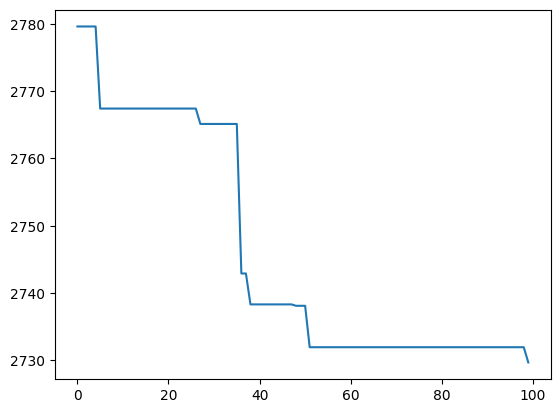

In [13]:
from optalgotools.routing import draw_route
import matplotlib.pyplot as plt
print("Cost of the route:",cost(G,route))
ax = plt.plot(states)

In [14]:
draw_route(G,route)